# TODO
- Save max acc epoch
- Read sep train set, validation set

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [2]:
print( f"TensorFlow {tf.__version__}" )
import sys
print( f"Python {sys.version}\n" )


TensorFlow 2.6.0
Python 3.9.17 (main, Jul  5 2023, 21:22:06) [MSC v.1916 64 bit (AMD64)]



In [3]:
model_input_h = 224  #input('image size :',)
train_batch_size = 50  #input('batch size :', )
if model_input_h == '':
    model_input_w = 224
    model_input_h = 224
else:
    model_input_h = int(model_input_h)
    model_input_w = model_input_h


if train_batch_size == '':
    train_batch_size = 100
else:
    train_batch_size = int(train_batch_size)
    
print(f'image size :{model_input_w}x{model_input_h}')
print('batch size :', train_batch_size)

image size :224x224
batch size : 50


# Read data

In [225]:
def read_infer_label(path, subset=None, size= (300,300), batch_size= 2, shuffle= False, validation_split=0.2):
    # directory = './resize/'
    # directory = './raw_data/'
    tf_raw_data = tf.keras.utils.image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode= 'int',#'categorical',
        # label_mode= 'int',#'categorical',
        class_names=None,
        color_mode='rgb',
        batch_size=batch_size,
        image_size=size,
        shuffle=shuffle, 
        seed=42,
        validation_split=validation_split,
        subset=subset,
        interpolation='bilinear',
        follow_links=False,
        crop_to_aspect_ratio=False
    )
    return tf_raw_data

In [180]:
# subet = 'validation'
# subset = 'training'

In [181]:
# raw_train = read_infer_label('./raw_data_train/', size= (model_input_w, model_input_h), batch_size= train_batch_size)
# raw_test = read_infer_label('./raw_data_test/', size= (model_input_w, model_input_h), batch_size= train_batch_size)

In [182]:
train_batch_size = 32

In [273]:
raw_train = read_infer_label('./raw_data_train/', subset='training', size= (model_input_w, model_input_h), batch_size= train_batch_size, shuffle= True)
raw_test = read_infer_label('./raw_data_train/', subset='validation', size= (model_input_w, model_input_h), batch_size= train_batch_size, shuffle= True)

Found 703 files belonging to 4 classes.
Using 563 files for training.
Found 703 files belonging to 4 classes.
Using 140 files for validation.


In [274]:
import os

# Set the directory containing your dataset
data_directory = './raw_data_train'

# Initialize an empty dictionary to store the counts for each class
class_counts = {}

# Iterate over the subdirectories in the main data directory
for class_name in os.listdir(data_directory):
    class_path = os.path.join(data_directory, class_name)
    if os.path.isdir(class_path):
        class_count = len(os.listdir(class_path))
        class_counts[class_name] = class_count

# Display the counts for each class
for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Count: {count}")
    
print(raw_train.class_names)# == np.array([0.,1.,0.,0.])

Class: adventure, Count: 73
Class: cruiser, Count: 204
Class: dirt, Count: 193
Class: sport, Count: 234
['adventure', 'cruiser', 'dirt', 'sport']


# Pre processing

## Data Augmentation

In [275]:
dataaug = tf.keras.models.Sequential( [
                                          tf.keras.Input(shape=(model_input_w, model_input_h,3)),
                                          tf.keras.layers.RandomFlip(mode='horizontal', name='rand_flip'),
                                        #   tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='reflect', name='rand_trans'),
                                          tf.keras.layers.RandomRotation(factor=0.05, fill_mode='wrap', name='rand_rot'),
                                          tf.keras.layers.RandomZoom(height_factor=  (-0.3, -0.2), fill_mode= 'constant'),
                                          # tf.keras.layers.RandomContrast(factor= 0.7)
                                          # tf.keras.layers.RandomBrightness(factor = 0.3)
                                          # tf.keras.layers.RandomCrop(model_input_w, model_input_h, seed=42, name= 'rans_crop')
                                      ],
                                     name='dataaug' )

dataaug.summary()

Model: "dataaug"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rand_flip (RandomFlip)       (None, 224, 224, 3)       0         
_________________________________________________________________
rand_rot (RandomRotation)    (None, 224, 224, 3)       0         
_________________________________________________________________
random_zoom_6 (RandomZoom)   (None, 224, 224, 3)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [276]:
# Define a function to apply the sequential pipeline to the data
def apply_pipeline(image, label):
    return dataaug(image), label

# Apply the sequential pipeline to the dataset
augmented_data = raw_train.map(apply_pipeline)

# Iterate over the dataset and display the augmented images
# c = 0
# for images, labels in augmented_data:
#     for i in range(len(images)):
#         plt.imshow(images[i] / 255)  # Assuming the images are in the range [0, 255]
#         plt.title(f"Label: {labels[i]}")
#         plt.show()
#         # c+=1
#         continue
#         # if c > 10:
#         #     breako
#         # break
#     # end
#     break
    

1


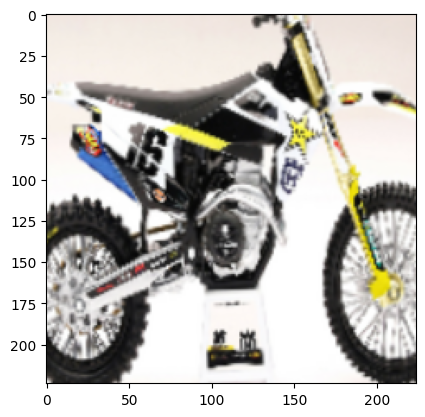

In [277]:
a = augmented_data.as_numpy_iterator()
plt.imshow(a.next()[0][0] / 255)
print(a.next()[1][0])

## Concat Raw and Augemented data

In [278]:
full_train = raw_train.concatenate(augmented_data)
# TODO ไม่ต้อง concat เอา augment มาอย่างเดียว

## Scaling

In [279]:
scaling_layers = [
    tf.keras.Input(shape= (model_input_w, model_input_h,3)),
    tf.keras.layers.Rescaling(1./255)
    
]

data_scaling = tf.keras.models.Sequential(
    scaling_layers,
    name= 'data_scaling'
)

data_scaling.summary()


Model: "data_scaling"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 224, 224, 3)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [280]:
scaling_bool = True

In [281]:
if scaling_bool == True:
    # Define a function to apply the sequential pipeline to the data
    def apply_scaling(image, label):
        return data_scaling(image), label

    # Apply the sequential pipeline to the dataset
    full_train_prep = full_train.map(apply_scaling)
    print('rescale')

    ## Iterate over the dataset and display the augmented images
    # c = 0
    # for images, labels in full_train_prep:
    #     for i in range(len(images)):
    #         plt.imshow(images[i])  # Assuming the images are in the range [0, 255]
    #         plt.title(f"Label: {labels[i]}")
    #         plt.show()
    #         # c+=1
    #         continue
    #         # if c > 10:
    #         #     break
    #         # break
    #     # end
    #     break
else:
    full_train_prep = full_train

        

rescale


## Data Details

In [282]:
batch = full_train_prep.as_numpy_iterator().next()
print('total data :', len(batch[0]) * len(full_train_prep))
print('N batch :', len(full_train_prep))
print('data shape :',batch[0][0].shape)
print('label example : ',batch[1][0])

total data : 1152
N batch : 36
data shape : (224, 224, 3)
label example :  3


# Transfer learning

## Get pre-trained model

### Exclude TOP

In [283]:
resnet_model = tf.keras.applications.ResNet50V2(
    include_top=False, # true จะใส่เขียวมา (ใส่ dense layer มาให้)
    # false จะไม่เอา dense สีเขียวมา
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling='avg',
    classes=1000,
    classifier_activation="softmax",
)

In [284]:
resnet_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_28[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

# Pre test

### Freeze layers

### train only BN

In [285]:
for i in resnet_model.layers:
    # print(type(i.name))
    if '_bn' in i.name:
        print(i.name)

conv2_block1_preact_bn
conv2_block1_1_bn
conv2_block1_2_bn
conv2_block2_preact_bn
conv2_block2_1_bn
conv2_block2_2_bn
conv2_block3_preact_bn
conv2_block3_1_bn
conv2_block3_2_bn
conv3_block1_preact_bn
conv3_block1_1_bn
conv3_block1_2_bn
conv3_block2_preact_bn
conv3_block2_1_bn
conv3_block2_2_bn
conv3_block3_preact_bn
conv3_block3_1_bn
conv3_block3_2_bn
conv3_block4_preact_bn
conv3_block4_1_bn
conv3_block4_2_bn
conv4_block1_preact_bn
conv4_block1_1_bn
conv4_block1_2_bn
conv4_block2_preact_bn
conv4_block2_1_bn
conv4_block2_2_bn
conv4_block3_preact_bn
conv4_block3_1_bn
conv4_block3_2_bn
conv4_block4_preact_bn
conv4_block4_1_bn
conv4_block4_2_bn
conv4_block5_preact_bn
conv4_block5_1_bn
conv4_block5_2_bn
conv4_block6_preact_bn
conv4_block6_1_bn
conv4_block6_2_bn
conv5_block1_preact_bn
conv5_block1_1_bn
conv5_block1_2_bn
conv5_block2_preact_bn
conv5_block2_1_bn
conv5_block2_2_bn
conv5_block3_preact_bn
conv5_block3_1_bn
conv5_block3_2_bn
post_bn


In [286]:
resnet_fz =resnet_model

for layer in resnet_fz.layers:
    if '_bn' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

### freeza all layer

In [287]:
# resnet_fz =resnet_model

# for layer in resnet_fz.layers:
#     layer.trainable = False

### batch norm
- https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/

### TODO read
- https://towardsdatascience.com/a-bunch-of-tips-and-tricks-for-training-deep-neural-networks-3ca24c31ddc8




In [288]:
# -  The base model contains batchnorm layers. We want to keep them in inference mode
# -  when we unfreeze the base model for fine-tuning, so we make sure that the
# -  base_model is running in inference mode here.
# x = base_model(x, training=False)
# x = keras.layers.GlobalAveragePooling2D()(x)
# 
# outputs = keras.layers.Dense(1)(x)
# model = keras.Model(inputs, outputs)

In [289]:
inputs = tf.keras.Input(shape= (224,224,3))
x = resnet_fz(inputs, training= False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.4)(x) 
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1024, activation= 'relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)  # Regularize with dropout
x = tf.keras.layers.Dense(512, activation= 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x) 
x = tf.keras.layers.Dense(64, activation= 'relu')(x)
outputs = tf.keras.layers.Dense(4, activation= 'softmax')(x)


### Include TOP

In [290]:
# resnet_model = tf.keras.applications.ResNet50V2(
#     include_top=True, # true จะใส่เขียวมา (ใส่ dense layer มาให้)
#     # false จะไม่เอา dense สีเขียวมา
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=(224,224,3),
#     pooling='avg',
#     classes=1000,
#     classifier_activation="softmax",
# )

# inputs = tf.keras.Input(shape= (224,224,3))
# x = resnet_fz(inputs, training= False)

# outputs = tf.keras.layers.Dense(4, activation= 'softmax')(x)

# transfer_model = tf.keras.Model(inputs, outputs)




In [291]:
transfer_model = tf.keras.Model(inputs, outputs)
transfer_model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
flatten_7 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 2048)              0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_28 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_22 (Dropout)         (None, 1024)              0   

## Train with callback method

In [292]:
from tensorflow.keras.callbacks import Callback

class MaxAccuracyEpochScoreSaver(Callback):
    def __init__(self):
        super(MaxAccuracyEpochScoreSaver, self).__init__()
        self.max_val_accuracy = 0.0
        self.max_val_epoch = 0
        self.scores = {}

    def on_epoch_end(self, epoch, logs=None):
        current_val_accuracy = logs['val_accuracy']
        if current_val_accuracy > self.max_val_accuracy:
            self.max_val_accuracy = current_val_accuracy
            self.max_val_epoch = epoch + 1
            self.scores = {
                'Epoch': self.max_val_epoch,
                'Training Loss': logs['loss'],
                'Training Accuracy': logs['accuracy'],
                'Validation Loss': logs['val_loss'],
                'Validation Accuracy': logs['val_accuracy']
            }

    def on_train_end(self, logs=None):
        print("Max Accuracy Epoch Scores:")
        for key, value in self.scores.items():
            print(f"{key}: {value}")




In [293]:
# lr = 0.005
# _optimizer = tf.keras.optimizers.Adam( ema_momentum= 0.90)     
# transfer_model.compile(optimizer= _optimizer, #'adam',
#                      loss= 'categorical_crossentropy',
#                      metrics= ['accuracy'])

transfer_model.compile(optimizer= 'adam',
                     loss= 'sparse_categorical_crossentropy',
                     metrics= ['accuracy'])

# transfer_model.compile(optimizer= 'adam', #'adam
#                      loss= 'categorical_crossentropy',
#                      metrics= ['accuracy'])

In [294]:
# Create an instance of the callback
max_accuracy_saver = MaxAccuracyEpochScoreSaver()

# Add the callback to the list of callbacks when fitting the model
# transfer_model.fit(full_train_prep, epochs=2, validation_data=raw_test, callbacks=[max_accuracy_saver])
transfer_model.fit(full_train, epochs=1, validation_data=raw_test, callbacks=[max_accuracy_saver])

36/36 [==============================] - 28s 589ms/step - loss: 1.2071 - accuracy: 0.4769 - val_loss: 1.9926 - val_accuracy: 0.3643
Max Accuracy Epoch Scores:
Epoch: 1
Training Loss: 1.2071335315704346
Training Accuracy: 0.4769093990325928
Validation Loss: 1.992558479309082
Validation Accuracy: 0.3642857074737549


In [295]:
# # Create an instance of the callback
# max_accuracy_saver = MaxAccuracyEpochScoreSaver()

# # Add the callback to the list of callbacks when fitting the model
# # transfer_model.fit(full_train_prep, epochs=2, validation_data=raw_test, callbacks=[max_accuracy_saver])
# transfer_model.fit(raw_train.map(apply_scaling), epochs=30, validation_data=raw_test, callbacks=[max_accuracy_saver])

In [296]:
# transfer_model.fit(full_train_prep, epochs= 2)#, validation_data= raw_test)

# Evaluate

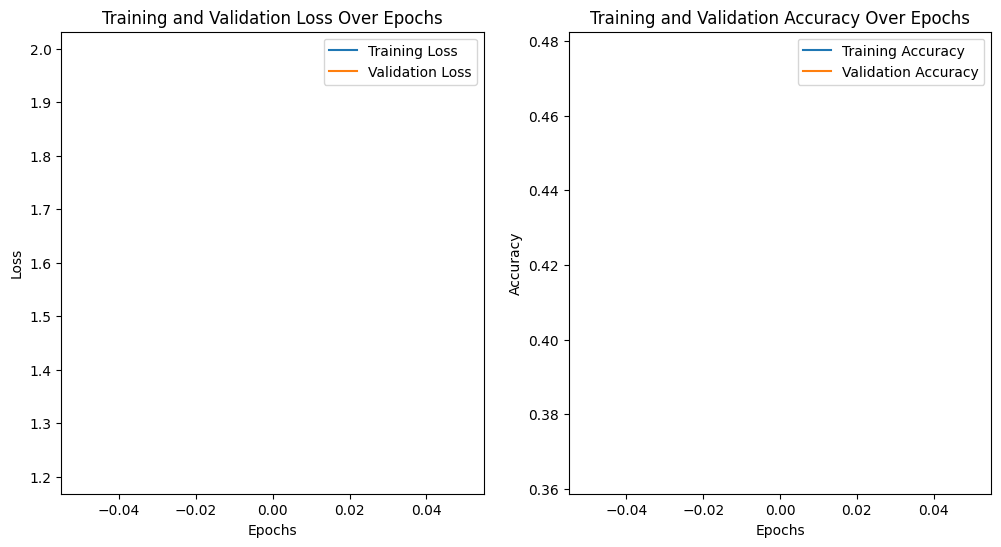

In [297]:


# Assuming 'transfer_model' is the trained model
history = transfer_model.history.history

# Retrieve the training and validation loss and accuracy
train_loss = history['loss']
val_loss = history['val_loss']
train_acc = history['accuracy']
val_acc = history['val_accuracy']

# Create a plot for training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Create a plot for training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Display the plots
plt.show()


In [298]:
# TODO
# หลักจากได้ model แล้ว
# เอามา learn 3 รอบ โดยให้แต่ระรอบเซฟ learning rate ลง csv
# 3รอบ batch size ลง csv

In [299]:
loss, acc = transfer_model.evaluate(raw_test)
print('loss :', loss)
print('acc :', acc)



5/5 [==============================] - 2s 106ms/step - loss: 1.9926 - accuracy: 0.3643
loss : 1.9925587177276611
acc : 0.3642857074737549


In [300]:
label_lst = raw_train.class_names

In [267]:

# raw_test3 = read_infer_label('./raw_data_test/',validation_split= None , subset=None, size= (model_input_w, model_input_h), batch_size= train_batch_size, shuffle= True)

Found 173 files belonging to 4 classes.


In [301]:
# unbatched = np.array([[data[0].numpy(), data[1].numpy()] for data in raw_test.unbatch()])
# test_images = np.array([data[0] for data in unbatched])
# test_labels = np.array([data[1] for data in unbatched])

C:\Users\kimte\AppData\Local\Temp\ipykernel_23348\2043050565.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  unbatched = np.array([[data[0].numpy(), data[1].numpy()] for data in raw_test.unbatch()])


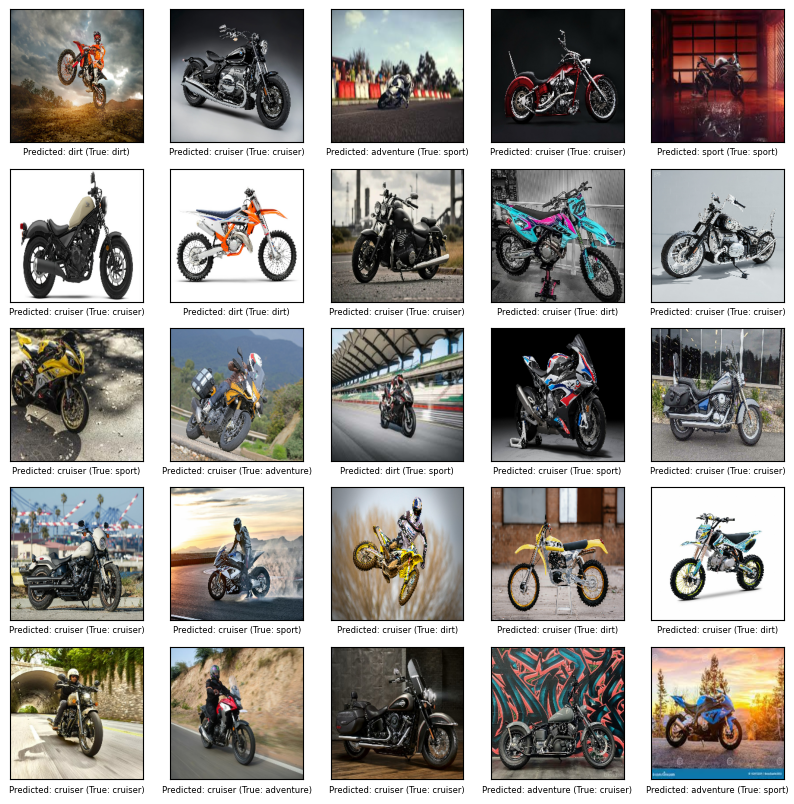

In [302]:
# buffer_size = 1000

# # Shuffle the BatchDataset
# shuffled_test = raw_test.shuffle(buffer_size)
# shuffled_test = raw_test
# Function to display a sample of images along with their predicted labels
def plot_sample_images(images, labels, predictions=None):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(zip(images, labels)):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image / 255.0)
        if predictions is not None:
            predicted_label = np.argmax(predictions[i])
            # print(predicted_label)
            true_label = label#np.argmax(label)
            plt.xlabel(f"Predicted: {label_lst[predicted_label]} (True: {label_lst[true_label]})", fontsize=6)
        # else:
        #     true_label = label #np.argmax(label)
        #     plt.xlabel(f"True: {true_label}")
        # print('true :', label, 'pred :', predicted_label, 'predict :', predictions[i])
    plt.show()

# Convert the test data to numpy arrays
unbatched = np.array([[data[0].numpy(), data[1].numpy()] for data in raw_test.unbatch()])
test_images = np.array([data[0] for data in unbatched])
test_labels = np.array([data[1] for data in unbatched])

# Generate predictions on the test images
predictions = transfer_model.predict(raw_test)

# Plot a sample of the test images with their true and predicted labels
plot_sample_images(test_images[:25], test_labels[:25], predictions[:25])

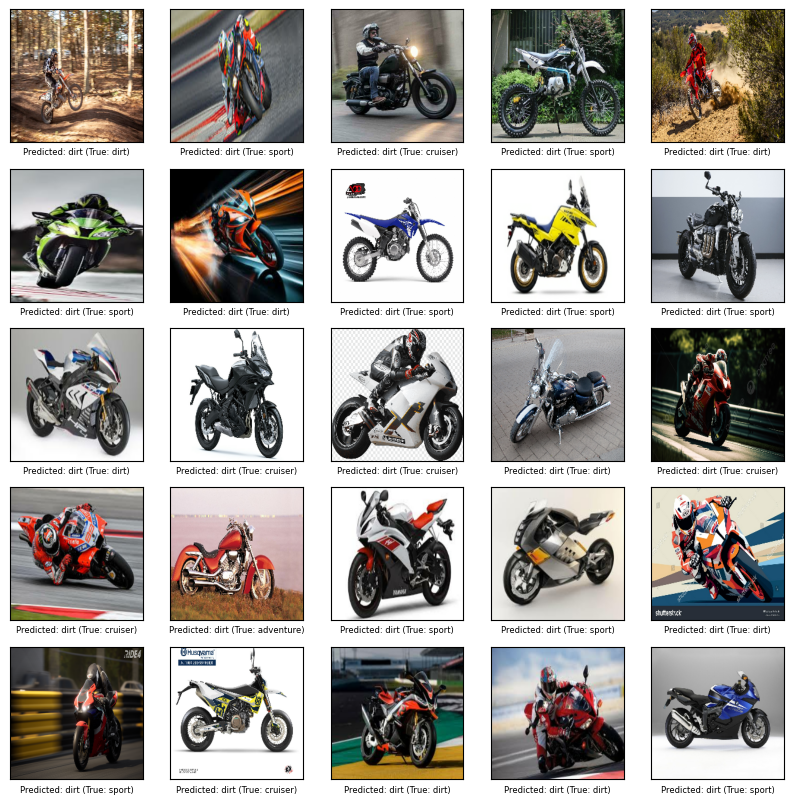

In [228]:
# # buffer_size = 1000

# # # Shuffle the BatchDataset
# # shuffled_test = raw_test.shuffle(buffer_size)
# shuffled_test = raw_test3
# # Function to display a sample of images along with their predicted labels
# def plot_sample_images(images, labels, predictions=None):
#     plt.figure(figsize=(10, 10))
#     for i, (image, label) in enumerate(zip(images, labels)):
#         plt.subplot(5, 5, i + 1)
#         plt.xticks([])
#         plt.yticks([])
#         plt.grid(False)
#         plt.imshow(image / 255.0)
#         if predictions is not None:
#             predicted_label = np.argmax(predictions[i])
#             # print(predicted_label)
#             true_label = label#np.argmax(label)
#             plt.xlabel(f"Predicted: {label_lst[predicted_label]} (True: {label_lst[true_label]})", fontsize=6)
#         # else:
#         #     true_label = label #np.argmax(label)
#         #     plt.xlabel(f"True: {true_label}")
#         # print('true :', label, 'pred :', predicted_label, 'predict :', predictions[i])
#     plt.show()

# # Convert the test data to numpy arrays
# test_images = np.array([data[0].numpy() for data in shuffled_test.unbatch()])
# test_labels = np.array([data[1].numpy() for data in shuffled_test.unbatch()])

# # Generate predictions on the test images
# predictions = transfer_model.predict(shuffled_test)

# # Plot a sample of the test images with their true and predicted labels
# plot_sample_images(test_images[:25], test_labels[:25], predictions[:25])

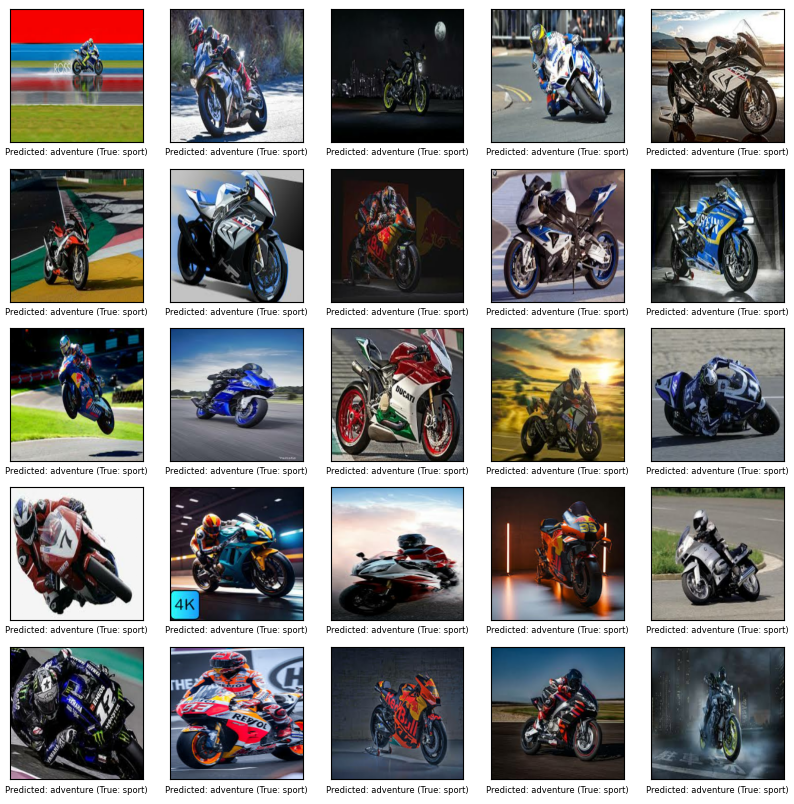

In [147]:
# Function to display a sample of images along with their predicted labels
def plot_sample_images(images, labels, predictions=None):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(zip(images, labels)):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image / 255.0)
        if predictions is not None:
            predicted_label = np.argmax(predictions[i])
            true_label = label#np.argmax(label)
            plt.xlabel(f"Predicted: {label_lst[predicted_label]} (True: {label_lst[true_label]})", fontsize=6)
        # else:
        #     true_label = label #np.argmax(label)
        #     plt.xlabel(f"True: {true_label}")
        # print('true :', label, 'pred :', predicted_label, 'predict :', predictions[i])
    plt.show()

# Convert the test data to numpy arrays
test_images = np.array([data[0].numpy() for data in raw_test.unbatch()])
test_labels = np.array([data[1].numpy() for data in raw_test.unbatch()])

# Generate predictions on the test images
predictions = transfer_model.predict(raw_test)

# Plot a sample of the test images with their true and predicted labels
plot_sample_images(test_images[:25], test_labels[:25], predictions[:25])

In [ ]:
# ['adventure', 'cruiser', 'dirt', 'sport']

In [33]:
def pred_one_img(model, img):
    img = np.expand_dims(img, axis=0)
    ret = model.predict(img)
    return ret[0]

In [87]:
label_lst = raw_train.class_names

TypeError: only integer scalar arrays can be converted to a scalar index

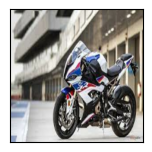

In [88]:
# Function to display a sample of images along with their predicted labels
def plot_sample_images(images, labels, predictions=None):
    global num_plot
    global label_lst
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(zip(images, labels)):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image / 255.0)
        if predictions is not None:
            predicted_label = np.argmax(predictions[i])
            true_label = np.argmax(label_lst[label])
            plt.xlabel(f"Pred: {label_lst[predicted_label]} (True: {label_lst[true_label]})",
                       fontsize= 6)
        else:
            true_label = np.argmax(label)
            plt.xlabel(f"True: {label_lst[true_label]}",fontsize= 6)
    plt.show()

# Convert the test data to numpy arrays
test_images = np.array([data[0].numpy() for data in raw_test.unbatch()])
test_labels = np.array([data[1].numpy() for data in raw_test.unbatch()])

# Generate predictions on the test images
predictions = transfer_model.predict(raw_test)

# Plot a sample of the test images with their true and predicted labels
num_plot = 50
plot_sample_images(test_images[:25], test_labels[:25], predictions[:25])
# plot_sample_images(test_images[:num_plot], test_labels[:num_plot], predictions[:num_plot])

In [162]:
test_labels[0]

array([0., 0., 0., 1.], dtype=float32)

In [35]:
# # Function to display a sample of images along with their predicted labels
# def plot_sample_images(images, labels, predictions=None):
#     global num_plot
#     global label_lst
#     plt.figure(figsize=(10, 10))
#     for i, (image, label) in enumerate(zip(images, labels)):
#         plt.subplot(5, 5, i + 1)
#         plt.xticks([])
#         plt.yticks([])
#         plt.grid(False)
#         plt.imshow(image / 255.0)
#         if predictions is not None:
#             predicted_label = np.argmax(predictions[i])
#             true_label = label_lst[np.argmax(label)]
#             print('pred :', predicted_label, 'true :', true_label)
#             plt.xlabel(f"Pred: {label_lst[predicted_label]} (True: {true_label})",
#                        fontsize= 6)
#         # else:
#         #     true_label = np.argmax(label)
#         #     plt.xlabel(f"True: {label_lst[true_label]}",fontsize= 6)
#     plt.show()

# # # Convert the test data to numpy arrays
# # test_images = np.array([data[0].numpy() for data in raw_test.unbatch()])
# # test_labels = np.array([data[1].numpy() for data in raw_test.unbatch()])

# # ## Generate predictions on the test images
# # # predictions = transfer_model.predict(raw_test)

# # predictions = []
# # for i in raw_test.as_numpy_iterator():
# # # for i in test_images:
# #     predictions.append(pred_one_img(transfer_model, i))

# test_images = []
# test_labels = []
# predictions = []
# c = 0
# for data in raw_test.unbatch().as_numpy_iterator():
#     test_img = data[0]
#     test_label = data[1]
#     test_images.append(test_img)
#     test_labels.append(test_labels)
#     predictions.append(pred_one_img(transfer_model, test_img))
#     c+=1
#     if c > 25:
#         break
    
    
    
    

# # Plot a sample of the test images with their true and predicted labels
# num_plot = 50
# plot_sample_images(test_images[:25], test_labels[:25], predictions[:25])
# # plot_sample_images(test_images[:num_plot], test_labels[:num_plot], predictions[:num_plot])

In [158]:
pred_one_img(transfer_model, i)

array([0.5034414 , 0.48249054, 0.00256648, 0.01150159], dtype=float32)

In [146]:
predictions[0]#[0][0]

array([[0.0010558 , 0.00918672, 0.97989655, 0.00986097]], dtype=float32)

In [138]:
for i in raw_test.unbatch().as_numpy_iterator():
    print(pred_one_img(transfer_model, i[0]))

[[0.08030122 0.69202924 0.18300106 0.04466844]]
[[0.07315964 0.13181925 0.46688616 0.32813492]]
[[0.2008665  0.72630405 0.00785112 0.06497827]]
[[0.23149137 0.40168738 0.07951035 0.2873109 ]]
[[0.07482732 0.3515746  0.47978956 0.09380846]]
[[0.23919111 0.26821303 0.01622258 0.4763733 ]]
[[0.00131176 0.12736566 0.02319088 0.84813166]]
[[0.00375063 0.05403981 0.21359938 0.7286102 ]]
[[0.00533958 0.020092   0.61804885 0.35651958]]
[[0.31167412 0.20349617 0.03350864 0.451321  ]]
[[0.19315247 0.26915887 0.07581396 0.4618747 ]]
[[0.14301442 0.3549856  0.11016605 0.391834  ]]
[[0.01741568 0.38859686 0.49514595 0.09884144]]
[[0.31126314 0.2865033  0.01950076 0.38273284]]
[[0.07266679 0.6113078  0.26611638 0.04990904]]
[[5.4115510e-01 4.5561549e-01 2.9936407e-04 2.9300551e-03]]
[[1.1689809e-04 1.0196004e-02 1.3806748e-02 9.7588038e-01]]
[[0.00069028 0.00305489 0.5469349  0.44932   ]]
[[5.5513583e-04 3.3116259e-02 4.7239266e-02 9.1908932e-01]]
[[0.00213826 0.00863047 0.60349894 0.38573232]]
[[0.

KeyboardInterrupt: 

In [133]:
for transfer_model.predict(np.expand_dims(_img, axis=0))

array([[0.00761571, 0.06879459, 0.9202028 , 0.00338692]], dtype=float32)

## Grad-CAM

In [51]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [25]:
# last_conv_layer_name = 'conv5_block3_out'
# img_path = './raw_data_test/adventure/TRK_STYLE.jpg'
# img_path = './raw_data_test/cruiser/rocket-front.jpg'
# img_array = get_img_array(img_path, (224,224))
# heatmap = make_gradcam_heatmap(img_array, resnet_fz, last_conv_layer_name, pred_index=None)
plt.imshow(heatmap)

NameError: name 'resnet_fz' is not defined

In [52]:
import matplotlib.cm as cm
from IPython.display import Image, display
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


# save_and_display_gradcam(img_path, heatmap)#, cam_path= )

In [54]:
last_conv_layer_name = 'conv5_block3_out'
for i in raw_test.unbatch().as_numpy_iterator():
    # print(pred_one_img(transfer_model, i[0]))
    img_array = i[0]
    # break
    # print(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    heatmap = make_gradcam_heatmap(img_array, resnet_fz, last_conv_layer_name)
    save_and_display_gradcam(img_array, heatmap)
    break
    

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xce in position 70812: invalid continuation byte

In [ ]:
for img_ in 

img_path_lst = [
    "./raw_data_test/adventure/timthumb.png",
    './raw_data_test/cruiser/tacita_urban_cruiser_blog.jpg',
    "./raw_data_test/dirt/MT-DB-X5-250cc_Black.jpg",
    './raw_data_test/sport/images535.jpg',
    
]

last_conv_layer_name = 'conv5_block3_out'
for img_path in img_path_lst:
    img_array = get_img_array(img_path, (224,224))
    heatmap = make_gradcam_heatmap(img_array, resnet_fz, last_conv_layer_name)
    save_and_display_gradcam(img_path, heatmap)


C:\Users\kimte\AppData\Local\Temp\ipykernel_20816\4131525126.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


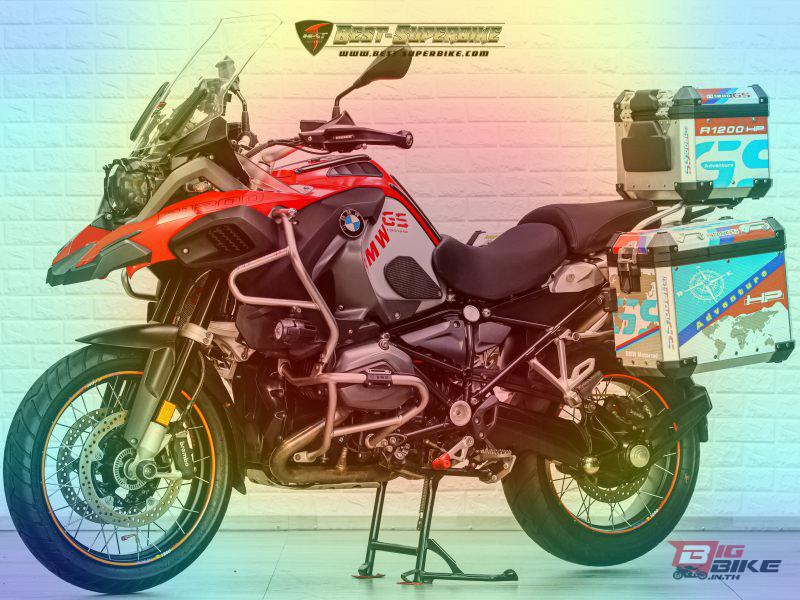

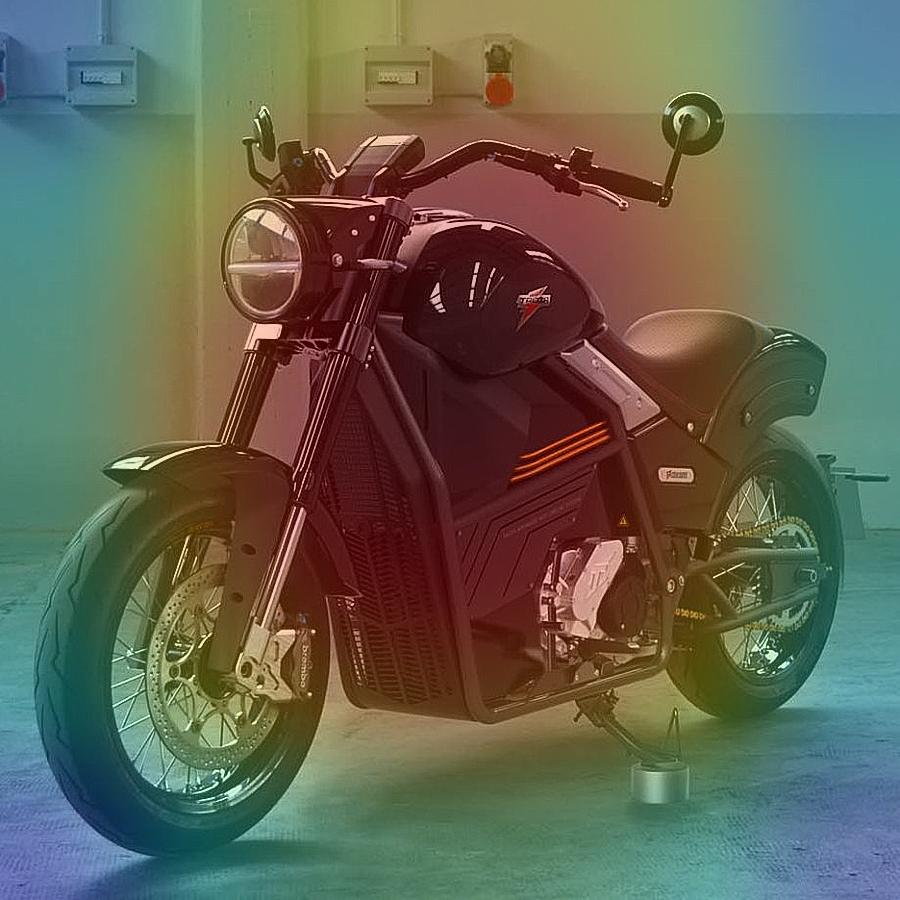

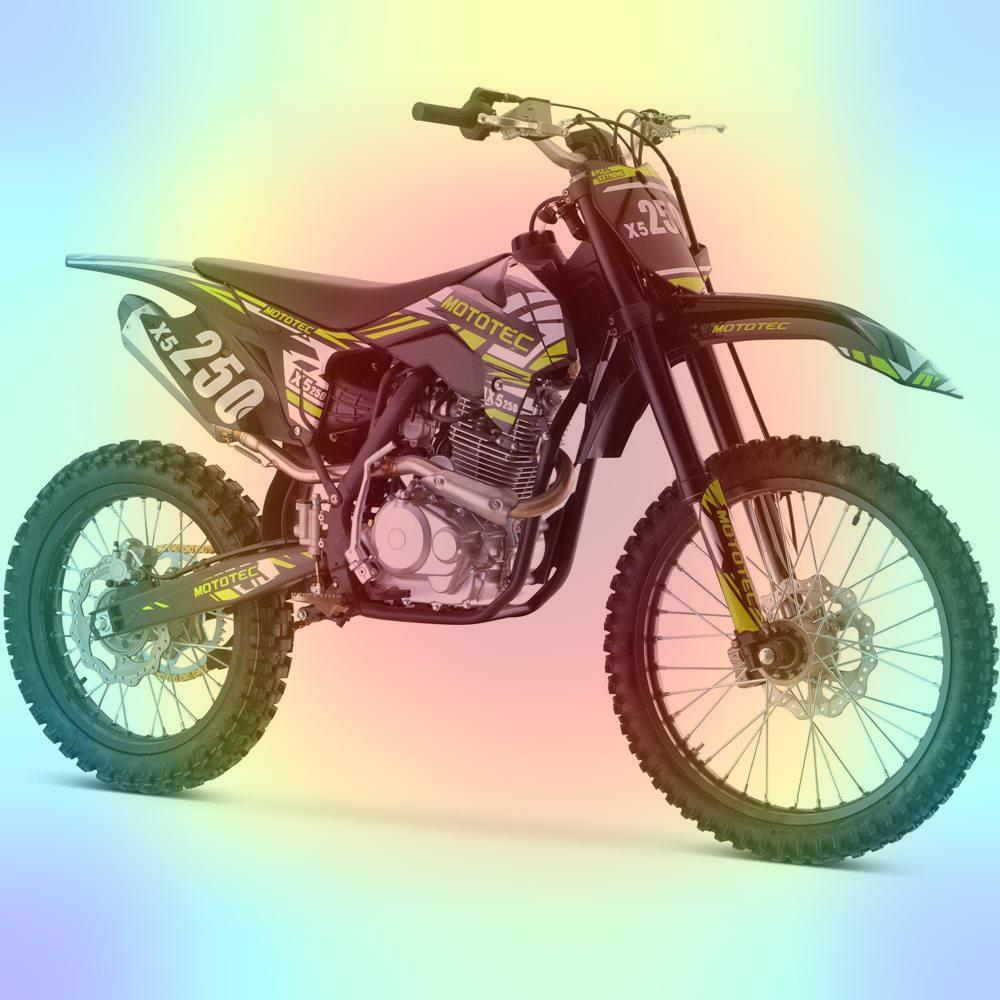

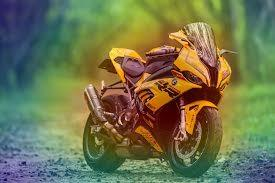

In [70]:
img_path_lst = [
    "./raw_data_test/adventure/timthumb.png",
    './raw_data_test/cruiser/tacita_urban_cruiser_blog.jpg',
    "./raw_data_test/dirt/MT-DB-X5-250cc_Black.jpg",
    './raw_data_test/sport/images535.jpg',
    
]

last_conv_layer_name = 'conv5_block3_out'
for img_path in img_path_lst:
    img_array = get_img_array(img_path, (224,224))
    heatmap = make_gradcam_heatmap(img_array, resnet_fz, last_conv_layer_name)
    save_and_display_gradcam(img_path, heatmap)


In [ ]:
label_lst

['adventure', 'cruiser', 'dirt', 'sport']

In [ ]:
_pred = transfer_model.predict(img_array)
_acutal = img_path.split('/')[-2]
print('Predict :',label_lst[np.argmax(_pred)], '\t Actual :', _acutal)

Predict : sport 	 Actual : cruiser


In [ ]:
_pred

array([[0.07532601, 0.13362598, 0.08462616, 0.7064219 ]], dtype=float32)

#### Autotune (caching??)

In [ ]:
tf.data.AUTOTUNE

-1

#### test rouding 

In [ ]:
print(f'{i:.6f}')

0.000677


In [ ]:
for i in transfer_model.predict(raw_test)[1]:
    print(f'{i:.6f}')

0.002387
0.981088
0.016520
0.000004
